In [1]:
import random
import pandas as pd
import numpy as np
from pathlib import Path
import os
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch

import matplotlib.pyplot as plt

class ConfigStruct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [3]:
config = dict(
    epochs=100,
    batch_size=2048,
    learning_rate=0.008,
    weight_decay=1e-5,
    dropout=0.05,
    shuffle=True,
    test_size=0.2,
    split_seed=42,
    random_seed=1234,
    stratified_split=False,
    smooth_l1_loss_beta=1.0
)

In [4]:
MODEL_FILENAME = "Model_A.pth"
MODEL_DIR = "../models"
MODEL_PATH = Path(MODEL_DIR, MODEL_FILENAME)

DATASET_DIR = "../data"
DATASET_NAME = "blue_waters_posix_no_outliers"
DATASET_PATH = Path(DATASET_DIR, DATASET_NAME).with_suffix(".csv")

CSV_LOG_PATH = "Model_A_test_loss.csv"

In [5]:
if not os.path.exists(CSV_LOG_PATH):
    with open(CSV_LOG_PATH, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "test_loss"])

In [6]:
# Load the data
df_blue_waters_posix = pd.read_csv(DATASET_PATH)
df_blue_waters_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,exe,lustre,bandwidth
0,1280,-1281,-1281,1807,0,0,2561,0,0,-1281,...,0.000000,0.000000,1540486184,1540486762,213,579.0,3.1,./Hsigma,1,0.883451
1,168420,-5232,-5232,7505724,5401751,11345341,394840,0,1,-5232,...,0.000000,1.294190,1540414582,1540499232,80,84651.0,3.1,./SpEC,1,126.224526
2,2366,-2367,-2367,3342,0,0,4733,0,0,-2367,...,0.000000,0.000000,1540498498,1540499201,394,704.0,3.1,./Hsigma,1,3.233117
3,8709,-288,-288,1521073,6331589,2013343,28430,0,0,-288,...,0.000000,56.737093,1540442491,1540443028,256,538.0,3.1,CCTM_v52_Linux2_x86_64intel,1,364.725531
4,8709,-288,-288,1516465,8334307,2006943,28430,0,0,-288,...,0.000000,56.462348,1540441741,1540442347,256,607.0,3.1,CCTM_v52_Linux2_x86_64intel,1,365.198932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724026,27899,-706,-706,824117,136902,632480,70722,0,1,-706,...,0.000000,0.914386,1506629880,1506630161,48,282.0,3.1,./SpEC,1,164.318747
724027,12571,-1000,-1000,781645,355445,653876,80989,0,1,-1000,...,0.000000,0.752825,1506647712,1506651237,48,3526.0,3.1,./SpEC,1,236.018095
724028,244,-77,-77,3960,5,2645,499,0,0,-77,...,0.000234,0.197681,1506699687,1506699703,1,17.0,3.1,ApplyObservers -domaininput=GrDomain.input -No...,1,97.547204
724029,9927,-890,-890,3640566,3018272,5706358,176916,0,1,-890,...,0.000000,0.715079,1506612023,1506695745,48,83723.0,3.1,./SpEC,1,141.832395


In [7]:
# Remove all records with zero in the "bandwidth" column
df_blue_waters_posix = df_blue_waters_posix[df_blue_waters_posix["bandwidth"] != 0]
df_blue_waters_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,exe,lustre,bandwidth
0,1280,-1281,-1281,1807,0,0,2561,0,0,-1281,...,0.000000,0.000000,1540486184,1540486762,213,579.0,3.1,./Hsigma,1,0.883451
1,168420,-5232,-5232,7505724,5401751,11345341,394840,0,1,-5232,...,0.000000,1.294190,1540414582,1540499232,80,84651.0,3.1,./SpEC,1,126.224526
2,2366,-2367,-2367,3342,0,0,4733,0,0,-2367,...,0.000000,0.000000,1540498498,1540499201,394,704.0,3.1,./Hsigma,1,3.233117
3,8709,-288,-288,1521073,6331589,2013343,28430,0,0,-288,...,0.000000,56.737093,1540442491,1540443028,256,538.0,3.1,CCTM_v52_Linux2_x86_64intel,1,364.725531
4,8709,-288,-288,1516465,8334307,2006943,28430,0,0,-288,...,0.000000,56.462348,1540441741,1540442347,256,607.0,3.1,CCTM_v52_Linux2_x86_64intel,1,365.198932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724026,27899,-706,-706,824117,136902,632480,70722,0,1,-706,...,0.000000,0.914386,1506629880,1506630161,48,282.0,3.1,./SpEC,1,164.318747
724027,12571,-1000,-1000,781645,355445,653876,80989,0,1,-1000,...,0.000000,0.752825,1506647712,1506651237,48,3526.0,3.1,./SpEC,1,236.018095
724028,244,-77,-77,3960,5,2645,499,0,0,-77,...,0.000234,0.197681,1506699687,1506699703,1,17.0,3.1,ApplyObservers -domaininput=GrDomain.input -No...,1,97.547204
724029,9927,-890,-890,3640566,3018272,5706358,176916,0,1,-890,...,0.000000,0.715079,1506612023,1506695745,48,83723.0,3.1,./SpEC,1,141.832395


In [8]:
# Separate bandwidth from input features
bandwidth_df = df_blue_waters_posix.pop('bandwidth')
bandwidth_df

0           0.883451
1         126.224526
2           3.233117
3         364.725531
4         365.198932
             ...    
724026    164.318747
724027    236.018095
724028     97.547204
724029    141.832395
724030    156.583380
Name: bandwidth, Length: 682576, dtype: float64

In [9]:
# Fix seeds for reproducibility
random.seed(config["random_seed"])
np.random.seed(config["random_seed"])

torch.manual_seed(config["random_seed"])
torch.cuda.manual_seed_all(config["random_seed"])

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [10]:
config = ConfigStruct(**config)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_blue_waters_posix,
                                                    bandwidth_df,
                                                    test_size=config.test_size,
                                                    random_state=config.split_seed,
                                                    stratify=df_blue_waters_posix["nprocs"] if config.stratified_split else None)

In [12]:
non_numeric_columns = X_train.select_dtypes(include='object').columns
non_numeric_columns

Index(['exe'], dtype='object')

In [13]:
X_train = X_train.drop(columns=non_numeric_columns)
X_train

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,lustre
295549,4766,-724,-724,212202,133752,201066,15301,0,1,-724,...,0.057065,0.653503,0.0,0.603932,1504955166,1504955744,48,579.0,3.1,1
120151,176,-34,-34,1254,792,1683,363,0,0,-34,...,0.215383,0.330592,0.0,0.002589,1534649192,1534649207,11,16.0,3.1,1
22415,567,-272,-272,4718,26400,14572,895,0,0,-272,...,0.025227,0.076052,0.0,0.057293,1574936848,1574937965,16,1118.0,3.1,1
410942,5660,-882,-882,517712,378991,586390,25734,0,1,-882,...,0.179827,0.276169,0.0,1.037294,1513028601,1513034925,48,6325.0,3.1,1
226986,13434,-1213,-1213,1544590,902708,1998069,79705,0,1,-1213,...,0.459195,0.780191,0.0,0.444116,1553121126,1553143162,48,22037.0,3.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275711,858,-20,-20,123598,42008793,16411,874,0,0,-20,...,0.199369,0.795786,0.0,206.708719,1568180340,1568190735,16,10396.0,3.1,1
390036,115,-13,-13,45728,10984,77,228,0,0,-13,...,0.022282,0.102872,0.0,0.556193,1568442086,1568442917,16,832.0,3.1,1
139924,53936,-1214,-1214,5245698,4359430,6529791,622129,0,1,-1214,...,0.145024,1.398725,0.0,1.309408,1506104852,1506185458,48,80607.0,3.1,1
711958,17621,-875,-875,3802721,3344715,5386709,391749,0,1,-875,...,0.166792,1.143757,0.0,29.847672,1506524219,1506608478,48,84260.0,3.1,1


In [14]:
X_test = X_test.drop(columns=non_numeric_columns)
X_test

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,lustre
150366,5127,-8,-8,17075,4763,500,2055,0,0,-8,...,0.035673,0.000573,0.000000,25.864859,1537159070,1537159666,1024,597.0,3.1,1
676351,1025,-1,-1,0,8,1,1,0,0,-1,...,0.000000,0.004506,0.000321,0.027398,1569490258,1569490322,1024,65.0,3.1,1
256465,8709,-288,-288,1520561,6330481,2010527,28430,0,0,-288,...,1.102125,0.653191,0.000000,69.096872,1537311375,1537312065,256,691.0,3.1,1
145355,137039,-8810,-8810,1600248,1033617,2270238,352317,0,1,-8810,...,0.285228,1.425272,0.000000,0.508379,1521653879,1521656037,128,2159.0,3.1,1
364279,3124,-20,-20,139011,25926804,60619,3188,0,0,-20,...,0.102943,1.188776,0.000000,123.398741,1562317432,1562318474,64,1043.0,3.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287709,4842,-790,-790,211116,131473,202624,14960,0,1,-790,...,0.323823,0.218312,0.000000,1.410457,1519226514,1519226624,48,111.0,3.1,1
239496,1025,-1,-1,0,8,1,1,0,0,-1,...,0.000000,0.001921,0.000037,0.025392,1569307785,1569307843,1024,59.0,3.1,1
718103,8709,-288,-288,1511994,6327001,2003389,28430,0,0,-288,...,102.788349,0.699649,0.000000,102.799000,1542411244,1542411896,256,653.0,3.1,1
438853,212,-14,-14,91456,13855,119,421,0,0,-14,...,0.081565,0.123856,0.000000,0.731534,1560516495,1560518532,32,2038.0,3.1,1


In [15]:
scaler = StandardScaler().fit(X_train)

In [16]:
# Scale the input features
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[-1.65770796e-02,  2.19197295e-02,  2.19197295e-02, ...,
        -4.79815428e-01,  3.55271368e-15,  1.72797895e-02],
       [-2.08262353e-02,  4.57778272e-02,  4.57778272e-02, ...,
        -5.00042759e-01,  3.55271368e-15,  1.72797895e-02],
       [-2.04642702e-02,  3.75485124e-02,  3.75485124e-02, ...,
        -4.60450363e-01,  3.55271368e-15,  1.72797895e-02],
       ...,
       [ 2.89416541e-02,  4.97702234e-03,  4.97702234e-03, ...,
         2.39541168e+00,  3.55271368e-15,  1.72797895e-02],
       [-4.67666629e-03,  1.66986095e-02,  1.66986095e-02, ...,
         2.52665581e+00,  3.55271368e-15,  1.72797895e-02],
       [-2.08382700e-02,  4.59852890e-02,  4.59852890e-02, ...,
        -4.96988899e-01,  3.55271368e-15,  1.72797895e-02]])

In [17]:
# Transform to a 2D array to avoid shape mismatch (gives errors)
tensor_X_train = torch.Tensor(X_train_scaled).to(device)
tensor_X_train

tensor([[-1.6577e-02,  2.1920e-02,  2.1920e-02,  ..., -4.7982e-01,
          3.5527e-15,  1.7280e-02],
        [-2.0826e-02,  4.5778e-02,  4.5778e-02,  ..., -5.0004e-01,
          3.5527e-15,  1.7280e-02],
        [-2.0464e-02,  3.7549e-02,  3.7549e-02,  ..., -4.6045e-01,
          3.5527e-15,  1.7280e-02],
        ...,
        [ 2.8942e-02,  4.9770e-03,  4.9770e-03,  ...,  2.3954e+00,
          3.5527e-15,  1.7280e-02],
        [-4.6767e-03,  1.6699e-02,  1.6699e-02,  ...,  2.5267e+00,
          3.5527e-15,  1.7280e-02],
        [-2.0838e-02,  4.5985e-02,  4.5985e-02,  ..., -4.9699e-01,
          3.5527e-15,  1.7280e-02]], device='cuda:0')

In [18]:
tensor_y_train = torch.Tensor(y_train.values).view(-1, 1).to(device)  
tensor_y_train

tensor([[ 51.1874],
        [ 30.3521],
        [314.0283],
        ...,
        [134.8450],
        [ 12.0241],
        [520.4371]], device='cuda:0')

In [19]:
training_dataset = TensorDataset(tensor_X_train, tensor_y_train)
training_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=config.shuffle)

In [20]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-1.62428867e-02,  4.66768280e-02,  4.66768280e-02, ...,
        -4.79168728e-01,  3.55271368e-15,  1.72797895e-02],
       [-2.00402804e-02,  4.69188667e-02,  4.69188667e-02, ...,
        -4.98282299e-01,  3.55271368e-15,  1.72797895e-02],
       [-1.29268789e-02,  3.69952811e-02,  3.69952811e-02, ...,
        -4.75791518e-01,  3.55271368e-15,  1.72797895e-02],
       ...,
       [-1.29268789e-02,  3.69952811e-02,  3.69952811e-02, ...,
        -4.77156773e-01,  3.55271368e-15,  1.72797895e-02],
       [-2.07929086e-02,  4.64693663e-02,  4.64693663e-02, ...,
        -4.27396820e-01,  3.55271368e-15,  1.72797895e-02],
       [-2.08327155e-02,  4.60544429e-02,  4.60544429e-02, ...,
        -4.97743382e-01,  3.55271368e-15,  1.72797895e-02]])

In [21]:
# Transform to a 2D array to avoid shape mismatch (gives errors)
tensor_X_test = torch.Tensor(X_test_scaled).to(device)
tensor_X_test

tensor([[-1.6243e-02,  4.6677e-02,  4.6677e-02,  ..., -4.7917e-01,
          3.5527e-15,  1.7280e-02],
        [-2.0040e-02,  4.6919e-02,  4.6919e-02,  ..., -4.9828e-01,
          3.5527e-15,  1.7280e-02],
        [-1.2927e-02,  3.6995e-02,  3.6995e-02,  ..., -4.7579e-01,
          3.5527e-15,  1.7280e-02],
        ...,
        [-1.2927e-02,  3.6995e-02,  3.6995e-02,  ..., -4.7716e-01,
          3.5527e-15,  1.7280e-02],
        [-2.0793e-02,  4.6469e-02,  4.6469e-02,  ..., -4.2740e-01,
          3.5527e-15,  1.7280e-02],
        [-2.0833e-02,  4.6054e-02,  4.6054e-02,  ..., -4.9774e-01,
          3.5527e-15,  1.7280e-02]], device='cuda:0')

In [22]:
tensor_y_test = torch.Tensor(y_test.values).view(-1, 1).to(device)  
tensor_y_test

tensor([[287.7923],
        [  8.1931],
        [310.6908],
        ...,
        [225.0734],
        [ 38.5242],
        [ 31.3455]], device='cuda:0')

In [23]:
test_dataset = TensorDataset(tensor_X_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size)

In [24]:
model = nn.Sequential(
    nn.Linear(102, 2048),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(2048, 512),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(128, 1),
).to(device)

In [25]:
loss_fn = nn.SmoothL1Loss(beta=config.smooth_l1_loss_beta, reduction="sum").to(device)

optimizer = optim.Adamax(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [26]:
model_epoch = 0

In [27]:
model.train()

Sequential(
  (0): Linear(in_features=102, out_features=2048, bias=True)
  (1): Dropout(p=0.05, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=2048, out_features=512, bias=True)
  (4): Dropout(p=0.05, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=128, bias=True)
  (7): Dropout(p=0.05, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
)

In [28]:
def train():
    size = len(training_dataloader)
    for batch, (X, y) in enumerate(training_dataloader):
        y_pred = model(X)

        # Divide the summed loss by the number of elements in the current batch to get the average loss
        loss = loss_fn(y, y_pred) / len(X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 100 == 0:
        #     loss = loss.item()
        #     print(f"loss: {loss:>7f} [{batch:>5d}/{size:>5d}]")

    model.train()

In [29]:
def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    # Divide the summed test loss by the number of elements in the whole test dataset to get the average loss
    test_loss /= len(test_dataloader.dataset)

    # print(f"Avg loss: {test_loss:>8f} \n")

    return test_loss

In [30]:
test_losses = []

for epoch in range(model_epoch, config.epochs):
    # print(f"Epoch {epoch + 1}\n-------------------------------")
    train()
    test_loss = test()

    scheduler.step(test_loss)

    model_epoch = epoch
    test_losses.append(test_loss)

    with open(CSV_LOG_PATH, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, test_loss])

    torch.save({
        'epoch': model_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, MODEL_PATH)

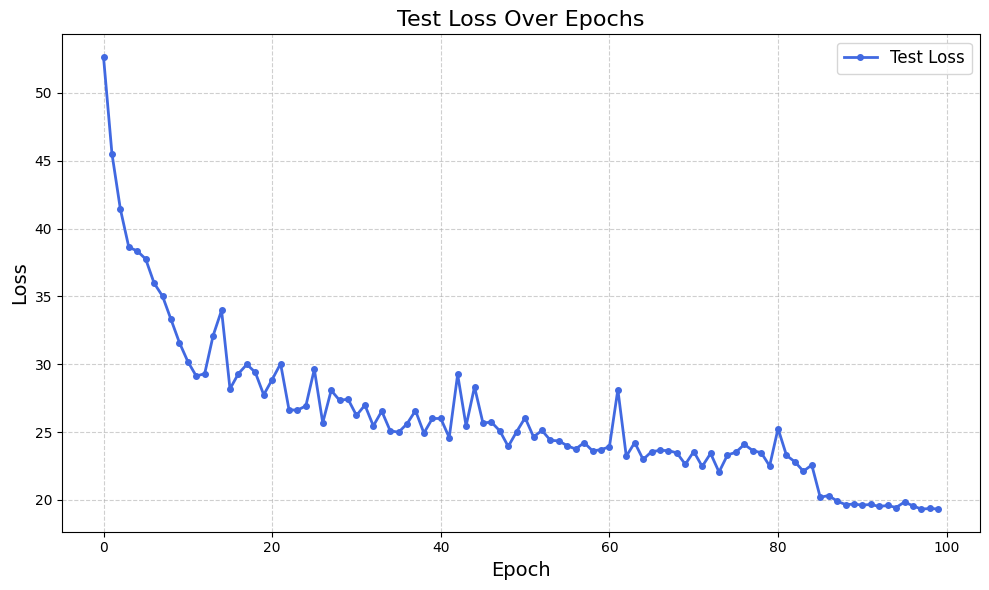

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(test_losses, label='Test Loss', color='royalblue', linewidth=2, marker='o', markersize=4)

plt.title("Test Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("Model_A_test_loss.png", dpi=300)
plt.show()